## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [5]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

jetUrl = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/02_Point/jet.bmp'
fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(jetUrl + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

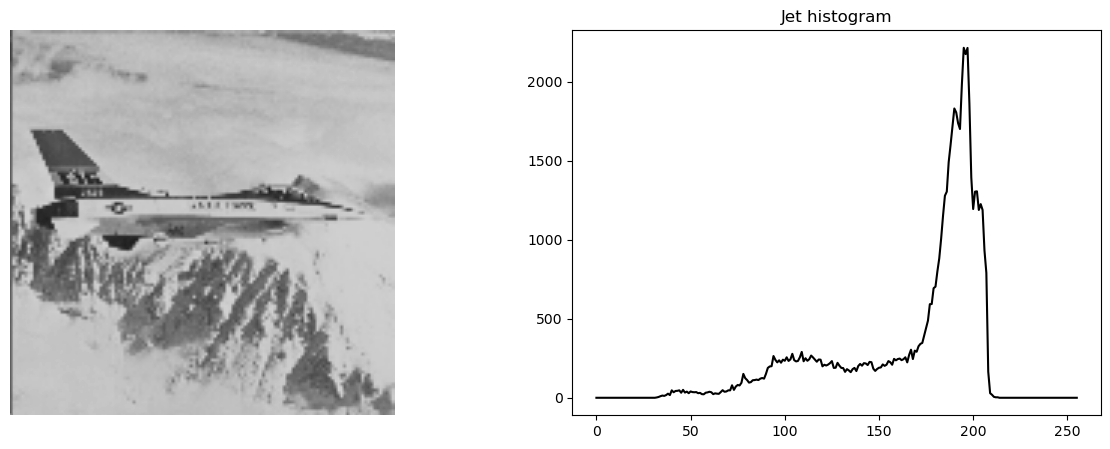

In [16]:
import cv2
from matplotlib import pyplot as plt

jet = cv2.imread('jet.bmp', cv2.IMREAD_GRAYSCALE)
jet_hist = cv2.calcHist([jet], [0], None, [256], [0, 256])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(jet, 'gray', vmin=0, vmax=256)
axs[0].axis('off')
axs[1].plot(jet_hist, color='black')
axs[1].set_title('Jet histogram')
plt.show()



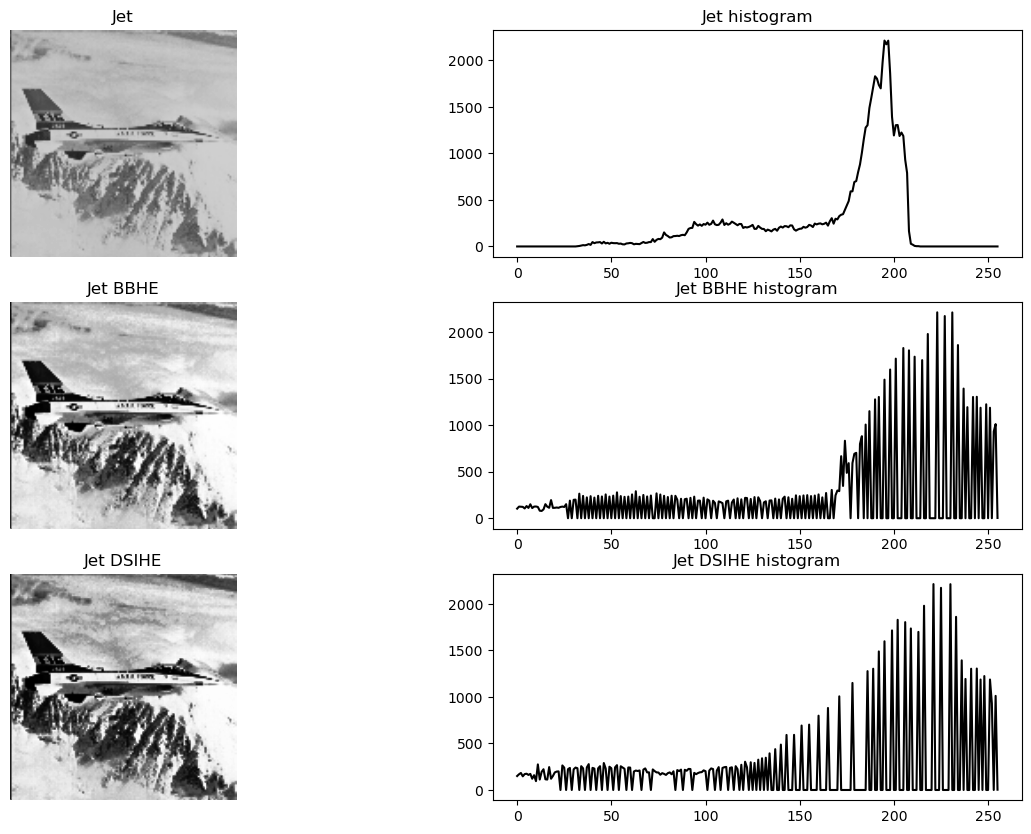

In [23]:
def BBHE(img):
    lm = np.mean(img) # average brightness
    img_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    
    img_hist1 = img_hist[:int(lm)]
    img_hist1_cum = np.cumsum(img_hist1)
    img_hist1_cum_norm = img_hist1_cum / max(img_hist1_cum)
    lut1 = np.uint8(lm * img_hist1_cum_norm)

    img_hist2 = img_hist[int(lm):]
    img_hist2_cum = np.cumsum(img_hist2)
    img_hist2_cum_norm = img_hist2_cum / max(img_hist2_cum)
    lut2 = np.uint8(lm + 1 + (255 - lm - 1) * img_hist2_cum_norm)
    
    lut = np.concatenate((lut1, lut2))  
    img_eq = cv2.LUT(img, lut)
    return img_eq

def DSIHE(img):
    img_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    img_hist_cum = np.cumsum(img_hist)
    img_hist_cum_norm = img_hist_cum / max(img_hist_cum)
    img_hist_cum_norm_half = abs(img_hist_cum_norm - 0.5)
    lm = np.argmin(img_hist_cum_norm_half) # median brightness
    
    img_hist1 = img_hist[:lm]
    img_hist1_cum = np.cumsum(img_hist1)
    img_hist1_cum_norm = img_hist1_cum / max(img_hist1_cum)
    lut1 = np.uint8(lm * img_hist1_cum_norm)

    img_hist2 = img_hist[lm:]
    img_hist2_cum = np.cumsum(img_hist2)
    img_hist2_cum_norm = img_hist2_cum / max(img_hist2_cum)
    lut2 = np.uint8(lm + 1 + (255 - lm - 1) * img_hist2_cum_norm)

    lut = np.concatenate((lut1, lut2))
    img_eq = cv2.LUT(img, lut)
    return img_eq


jet_eq_bbhe = BBHE(jet)
jet_eq_bbhe_hist = cv2.calcHist([jet_eq_bbhe], [0], None, [256], [0, 256])

jet_eq_dsihe = DSIHE(jet)
jet_eq_dsihe_hist = cv2.calcHist([jet_eq_dsihe], [0], None, [256], [0, 256])


fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs[0, 0].imshow(jet, 'gray', vmin=0, vmax=256)
axs[0, 0].axis('off')
axs[0, 0].set_title('Jet')
axs[0, 1].plot(jet_hist, color='black')
axs[0, 1].set_title('Jet histogram')
axs[1, 0].imshow(jet_eq_bbhe, 'gray', vmin=0, vmax=256)
axs[1, 0].axis('off')
axs[1, 0].set_title('Jet BBHE')
axs[1, 1].plot(jet_eq_bbhe_hist, color='black')
axs[1, 1].set_title('Jet BBHE histogram')
axs[2, 0].imshow(jet_eq_dsihe, 'gray', vmin=1, vmax=256)
axs[2, 0].axis('off')
axs[2, 0].set_title('Jet DSIHE')
axs[2, 1].plot(jet_eq_dsihe_hist, color='black')
axs[2, 1].set_title('Jet DSIHE histogram')
plt.show()